# Построение и обучение сверточной нейросети на Keras

## Цикл обучения
1. Подготовить данные 
2. Реализовать архитектуру модели
3. Задать процедуру оптимизации
4. Обучить
5. Проверить

### Пример - обучение сверточной сети для MNIST

* Загрузка необходимых модулей
* Основные типы подмодулей из keras:
  * model - для компиляции архитектуры, функции потерь и оптимизатора воедино
  * layers - разные типы слоев (и сверточные, и несверточные)
  * datasets - содержит предобработанные небольшие базы данных

In [4]:
import numpy as np
np.random.seed(12345)  # for reproducibility

import keras 
from keras.models import Model # compile model
from keras.layers import Dense, Flatten, Input # non-conv layeers
from keras.layers import Conv2D, MaxPooling2D # conv layers
from keras.utils import np_utils # one-hot encoding
from keras.datasets import mnist # preprocessed dataset
 
import matplotlib.pyplot as plt # visualization

* Загружаем предобработанную БД изображений цифр (0-9) в оттенках серого: MNIST
* MNIST содержит 60.000 изображений для обучения (по 6.000 для каждой цифры) и 10.000 для тестирования (по 1.000 для каждой цифры)

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


* Делаем дальнейшую предобработку данных:
  * Добавляем канал цвета (вторым), в данном случае он всегда будет содержать одну размерность, но для цветных изображений это будет уже 3 (RGB)
  * Меняем тип с uint8 на float32 и шкалируем в диапазон [0,1]

In [6]:
# NHW -> NCHW
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
# Byte -> [0,1]
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# Check range and type of input data
print(f'Min = {np.amin(X_train)} Max = {np.amax(X_train)} Type = {X_train.dtype}')

Min = 0.0 Max = 1.0 Type = float32


* Для функции потерь типа "перекрестная энтропия" делаем унитарное кодирование меток с помощью вспомогательной функции

In [7]:
# one-hot encoding
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

* Посмотрим на случайное изображение с номером 12345

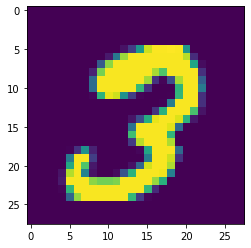

In [8]:
index = 12345
im = X_train[index, 0, :, :]
plt.imshow(im)
plt.show()

* Проверим его метку (как в обычном кодировании, так и в унитарном)

In [9]:
y_usual = y_train[index]
y_categorical = Y_train[index]
y_categorical_as_usual = np.argmax(y_categorical)
print(f'Usual label: {y_usual}')
print(f'Categorical label: {y_categorical}')
print(f'Categorical -> usual label: {y_categorical_as_usual}')

Usual label: 3
Categorical label: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Categorical -> usual label: 3


* Задаем архитектуру сети с помощью стандартных слоев
* Процедура задания в функциональном стиле: сеть = новый_слой(сеть)
* Можно задавать имя слоя с помощью параметра name
* В самом конце задаем формальный вход(ы) и выход(ы)

In [20]:
# Input
input_image = Input(shape=(1, 28, 28))
# Convolutions: take into account that can use activations without additional layer
conv1 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', data_format='channels_first')(input_image)
conv2 = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', data_format='channels_first')(conv1)
# Pooling
pool1 = MaxPooling2D(pool_size=(2,2), data_format='channels_first')(conv2)
# Flatten in order to have later FC
flatten = Flatten(name='My_flatten')(pool1)
# Fully connected layer1
dense1 = Dense(128, activation='relu')(flatten)
# Fully connected layer2 + SoftMax
dense2 = Dense(10, activation='softmax')(dense1)
# Input/output
model = Model(inputs=input_image, outputs=dense2)

* Можно посмотреть на краткую сводку по модели с помощью summary()
* Первая размерность - пакетная - будет обозначена как None
* Посмотрим на число параметров
* Также автоматически будут присвоены имена всем слоям, которым не было в явном порядке присвоено имя

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1, 28, 28)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 28, 28)         10        
Total params: 10
Trainable params: 10
Non-trainable params: 0
_________________________________________________________________


* Можно сохранить архитектуру сети как картинку

In [12]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

* Теперь "компилируем" модель, а именно задаем:
  * Функцию потерь
  * Оптимизатор
  * Метрики, которые будут вычисляться при обучении и тестировании (можно задать несколько, и даже разные для разных выходов)

In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

* Наконец запускаем обучение!
  * Для этого передаем на вход метода fit() обучающие данные с метками
  * Указываем, какую часть обучающих данных использовать для валидации
  * Указываем размер пакета данных для одной итерации оптимизации
  * Указываем количество эпох
* Выход - история обучения (потом проверим)

In [14]:
history = model.fit(X_train, Y_train, validation_split=0.25, batch_size=32, epochs=10, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 45000 samples, validate on 15000 samples
Epoch 1/10
45000/45000 [==============================] - 65s 1ms/step - loss: 0.1421 - acc: 0.9563 - val_loss: 0.0576 - val_acc: 0.9825
Epoch 2/10
45000/45000 [==============================] - 62s 1ms/step - loss: 0.0437 - acc: 0.9863 - val_loss: 0.0508 - val_acc: 0.9836
Epoch 3/10
10912/45000 [======>.......................] - ETA: 44s - loss: 0.0240 - acc: 0.9929

KeyboardInterrupt: 

* Посмотрим на историю обучения
  * Посмотрим как значения целевой функции потерь, так и на заданную метрику
  * Посмотрим и на валидацию так же

In [ ]:
# Plot training & validation metrics (accuracy) values 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

* Посчитаем функцию потерь и метрику на тесте с помощью метода evaluate()

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0)
# score = [loss, accuracy]
print(f'Test accuracy = {score[1]} Test loss = {score[0]}')

* Также можно посчитать вероятности классов по любому входу с помощью метода predict()

In [ ]:
pred_y = model.predict(X_test, verbose=0)

* Сравним для случайного изображения из теста его предсказание и правильный ответ

In [ ]:
index = 123
corr_ans = y_test[index]
pred_ans_categorical = pred_y[index]
pred_ans = np.argmax(pred_ans_categorical)
print(f'Correct answer = {corr_ans}')
print(f'Predicted probabilities = {pred_ans_categorical}')
print(f'Predicted class = {pred_ans}')



---



* Более полная информация по встроенным базам данных: [datasets](https://keras.io/api/datasets/)
* Более полная информация по встроенным слоям: [layers](https://keras.io/api/layers/)
* Более полная информация по функциям работы с моделью: [model](https://keras.io/api/models/model_training_apis/)